# Padding to multiples of 8

In [15]:
import torch
import numpy as np

def pad_by_8(in_tensor: torch.tensor, axis: int) -> torch.tensor:
  """Pads the specified axis of the tensor to be the nearest
  multiple of 8 that is larger than it's current size.

  Args:
    in_tensor (torch.tensor): The tensor to pad
    axis: (int): the axis to pad on

  Returns:
    torch.tensor: the padded tensor
  """
  if axis < 0 or axis >= in_tensor.ndim:
      raise ValueError(f"Axis {axis} is out of bounds for tensor with shape {in_tensor.shape}")

  current_size = in_tensor.size(axis)
  padding_needed = 8 - (current_size % 8)
  padding = [0] * (2 * in_tensor.ndim)
  padding[2 * axis + 1] = padding_needed

  # Reverse the padding tuple because PyTorch expects padding for last dimension first
  padding = tuple(padding[::-1])

  # Pad the tensor
  return torch.nn.functional.pad(in_tensor, padding, "constant", 0)

print("=== BEFORE PADDING ===")
A = np.arange(10).reshape(2,5)
B = np.arange(10).reshape(5,2)
print("A shape=", A.shape)
print(A)
print("-" * 50)
print("B shape=", B.shape)
print(B)
print("-" * 50)
print("A@B shape=", (A@B).shape)
print(A@B)
print("-" * 50)

print()
print("=== AFTER PADDING ===")
pad_A = pad_by_8(torch.from_numpy(A), 1)
pad_B = pad_by_8(torch.from_numpy(B), 0)

print("pad_A shape=", pad_A.shape)
print(pad_A)
print("-" * 50)
print("pad_B shape=", pad_B.shape)
print(pad_B)
print("-" * 50)
print("pad_A@pad_B shape=", (pad_A@pad_B).shape)
print(pad_A@pad_B)
print("-" * 50)

=== BEFORE PADDING ===
A shape= (2, 5)
[[0 1 2 3 4]
 [5 6 7 8 9]]
--------------------------------------------------
B shape= (5, 2)
[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
--------------------------------------------------
A@B shape= (2, 2)
[[ 60  70]
 [160 195]]
--------------------------------------------------

=== AFTER PADDING ===
pad_A shape= torch.Size([2, 8])
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [0, 0, 0, 5, 6, 7, 8, 9]])
--------------------------------------------------
pad_B shape= torch.Size([8, 2])
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
--------------------------------------------------
pad_A@pad_B shape= torch.Size([2, 2])
tensor([[ 60,  70],
        [160, 195]])
--------------------------------------------------


# M = 256

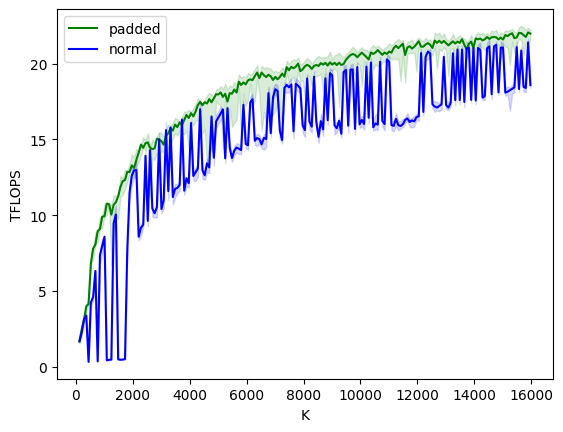

In [16]:
import torch
import triton

configs = [triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[8 * i for i in range(16, 2000, 10)],
            line_arg="method",
            line_vals=["padded", "normal"],
            line_names=["padded", "normal"],
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",
            plot_name="benchmark",
            args={"M": 256}
)]

@triton.testing.perf_report(configs)
def benchmark_matmul(K, method, M):
    K = K + torch.randint(1, 8, (1,)).item()
    A = torch.rand((M, K), device="cuda", dtype=torch.bfloat16)
    B = torch.rand((K, M), device="cuda", dtype=torch.bfloat16)
    pad_A = pad_by_8(A, axis=1)
    pad_B = pad_by_8(B, axis=0)

    quantiles = [0.5, 0.2, 0.8]
    if method == "normal":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(A, B), quantiles=quantiles)
    if method == "padded":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(pad_A, pad_B), quantiles=quantiles)

    perf = lambda ms: (2*K*M*M) * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark_matmul.run(show_plots=True, print_data=False) # set print_data = True to see a table of output

# M = 1024

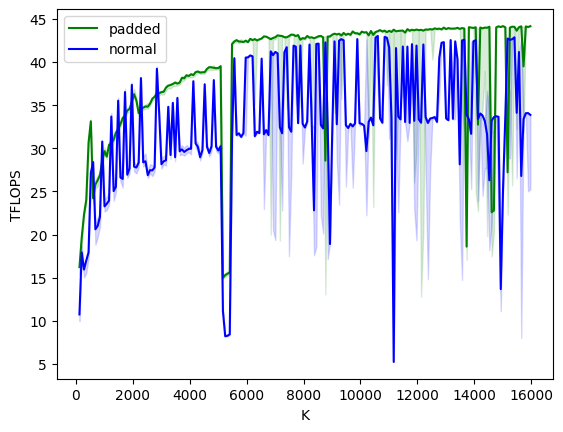

In [17]:
import torch
import triton

configs = [triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[8 * i for i in range(16, 2000, 10)],
            line_arg="method",
            line_vals=["padded", "normal"],
            line_names=["padded", "normal"],
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",
            plot_name="benchmark",
            args={"M": 1024}
)]

@triton.testing.perf_report(configs)
def benchmark_matmul(K, method, M):
    K = K + torch.randint(1, 8, (1,)).item()
    A = torch.rand((M, K), device="cuda", dtype=torch.bfloat16)
    B = torch.rand((K, M), device="cuda", dtype=torch.bfloat16)
    pad_A = pad_by_8(A, axis=1)
    pad_B = pad_by_8(B, axis=0)

    quantiles = [0.5, 0.2, 0.8]
    if method == "normal":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(A, B), quantiles=quantiles)
    if method == "padded":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(pad_A, pad_B), quantiles=quantiles)

    perf = lambda ms: (2*K*M*M) * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark_matmul.run(show_plots=True, print_data=False) # set print_data = True to see a table of output

# M = 4096

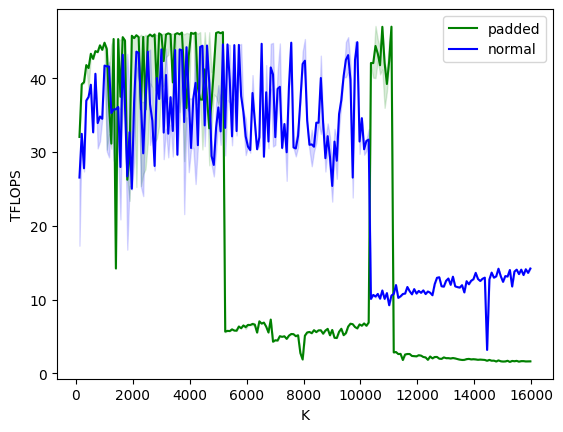

In [19]:
import torch
import triton

configs = [triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[8 * i for i in range(16, 2000, 10)],
            line_arg="method",
            line_vals=["padded", "normal"],
            line_names=["padded", "normal"],
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",
            plot_name="benchmark",
            args={"M": 4096}
)]

@triton.testing.perf_report(configs)
def benchmark_matmul(K, method, M):
    K = K + torch.randint(1, 8, (1,)).item()
    A = torch.rand((M, K), device="cuda", dtype=torch.bfloat16)
    B = torch.rand((K, M), device="cuda", dtype=torch.bfloat16)
    pad_A = pad_by_8(A, axis=1)
    pad_B = pad_by_8(B, axis=0)

    quantiles = [0.5, 0.2, 0.8]
    if method == "normal":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(A, B), quantiles=quantiles)
    if method == "padded":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(pad_A, pad_B), quantiles=quantiles)

    perf = lambda ms: (2*K*M*M) * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark_matmul.run(show_plots=True, print_data=False) # set print_data = True to see a table of output

# Change outer dimension

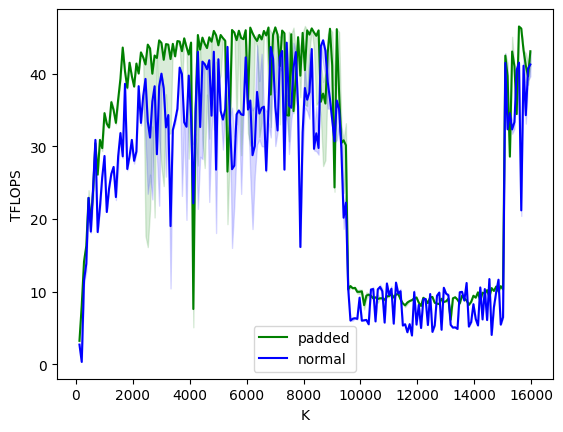

In [20]:
import torch
import triton

configs = [triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[8 * i for i in range(16, 2000, 10)],
            line_arg="method",
            line_vals=["padded", "normal"],
            line_names=["padded", "normal"],
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",
            plot_name="benchmark",
            args={"M": 1024}
)]

@triton.testing.perf_report(configs)
def benchmark_matmul(K, method, M):
    K = K + torch.randint(1, 8, (1,)).item()
    A = torch.rand((K, M), device="cuda", dtype=torch.bfloat16)
    B = torch.rand((M, K), device="cuda", dtype=torch.bfloat16)
    pad_A = pad_by_8(A, axis=0)
    pad_B = pad_by_8(B, axis=1)

    quantiles = [0.5, 0.2, 0.8]
    if method == "normal":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(A, B), quantiles=quantiles)
    if method == "padded":
      ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.mm(pad_A, pad_B), quantiles=quantiles)

    perf = lambda ms: (2*K*K*M) * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark_matmul.run(show_plots=True, print_data=False) # set print_data = True to see a table of output